In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F

In [2]:
device = torch.device("cuda")

In [3]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Będziemy używać augmentacji danych

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Data augmentation
transform_augment = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomRotation(24),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

batch_size = 128

# Load the dataset (augment only the training set)
full_dataset_augmented = torchvision.datasets.ImageFolder(
    "./train", transform=transform_augment
)
full_dataset_clean = torchvision.datasets.ImageFolder("./train", transform=transform)

# Train:validation:test proportions
# 90% train, 10% test (test dataset is also used for validation)
num_samples = len(full_dataset_augmented)
train_size = int(0.9 * num_samples)
test_size = num_samples - train_size
# val_size = num_samples - train_size - test_size

generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(num_samples), [train_size, test_size], generator=generator
)

# Create subsets for train, validation, and test
train_data = torch.utils.data.Subset(full_dataset_augmented, train_idx)
test_data = torch.utils.data.Subset(full_dataset_clean, val_idx)
# val_data = torch.utils.data.Subset(full_dataset_clean, test_idx)

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)
# validation_loader = torch.utils.data.DataLoader(
#     val_data, batch_size=batch_size, shuffle=False
# )

print(f"Train size: {len(train_loader.dataset)}")
# print(f"Test size: {len(validation_loader.dataset)}")
print(f"Validation size: {len(test_loader.dataset)}")

Train size: 79209
Validation size: 8802


/home/kamil/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


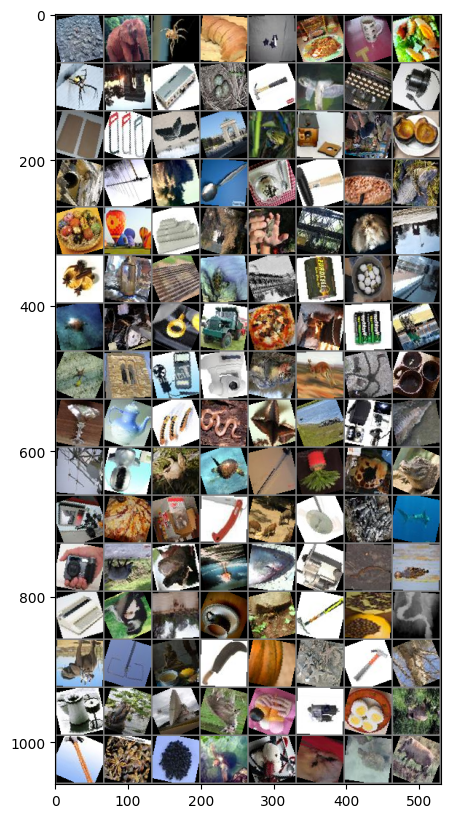

beetle elephant spider bread spice  bean   tea   egg spider memorial printer  nest hammer turtle printer motor towel   saw echinoderm memorial  frog camera bicycle squash acoustic antenna  bomb spoon icecream hammer  bean crocodilian   egg  bomb towel elephant  bird bridge   cat memorial spice   pot bridge turtle bridge battery   egg camera turtle motor gauge truck pizza carbon battery bicycle echinoderm acoustic gauge camera turtle kangaroo echinoderm   tea spoon   pot   saw snake spice crocodilian camera crocodilian antenna camera  frog turtle gauge  palm turtle crocodilian camera pizza   cat   saw swine antenna  bomb  fish camera swine crocodilian  bomb  fish motor snake crocodilian printer monkey elephant   tea  crab hammer spice  worm elephant antenna   tea   saw squash echinoderm hammer birch   pot crocodilian antenna kangaroo icecream motor   egg swine hammer spice  bean turtle icecream   cat turtle swine


In [5]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

classes = full_dataset_augmented.classes

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Niezbalansowanie klas nie jest duże

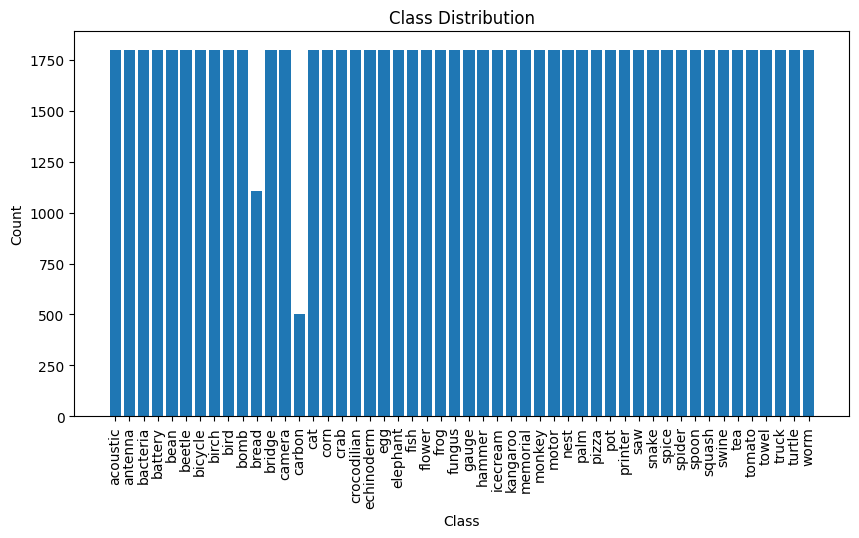

In [6]:
# Make plot of sizes of each class
class_counts = np.zeros(len(full_dataset_clean.classes))
for _, label in full_dataset_clean:
    class_counts[label] += 1

plt.figure(figsize=(10, 5))
plt.bar(range(len(class_counts)), class_counts)
plt.xticks(range(len(class_counts)), full_dataset_clean.classes, rotation=90)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 128, 5)
        self.bn_conv2 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.bn_conv3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn_conv4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(256, 256, 3)
        self.bn_conv5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 64, 3)
        self.bn_conv6 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 5 * 5, 256)
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn_conv2(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn_conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.bn_conv4(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.bn_conv5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.bn_conv6(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.batchnorm1(x)
        x = F.relu(self.fc2(x))
        x = self.batchnorm2(x)
        x = self.fc3(x)
        
        return x


net = Net().to(device)
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn_conv3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn_conv5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (con

In [8]:
# Print number of parameters
params_sum = 0
for params in net.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

1999154

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

[1/40] Train loss: 2.937
Validation loss: 2.574
Validation accuracy: 29.73%
[2/40] Train loss: 2.419
Validation loss: 2.325
Validation accuracy: 36.06%
[3/40] Train loss: 2.168
Validation loss: 2.067
Validation accuracy: 42.63%
[4/40] Train loss: 2.000
Validation loss: 1.950
Validation accuracy: 45.83%
[5/40] Train loss: 1.879
Validation loss: 1.837
Validation accuracy: 49.07%
[6/40] Train loss: 1.777
Validation loss: 1.789
Validation accuracy: 50.52%
[7/40] Train loss: 1.700
Validation loss: 1.722
Validation accuracy: 52.29%
[8/40] Train loss: 1.628
Validation loss: 1.706
Validation accuracy: 52.84%
[9/40] Train loss: 1.564
Validation loss: 1.646
Validation accuracy: 54.56%
[10/40] Train loss: 1.506
Validation loss: 1.593
Validation accuracy: 56.29%
[11/40] Train loss: 1.460
Validation loss: 1.546
Validation accuracy: 57.31%
[12/40] Train loss: 1.413
Validation loss: 1.529
Validation accuracy: 58.24%
[13/40] Train loss: 1.371
Validation loss: 1.512
Validation accuracy: 57.98%
[14/40] 

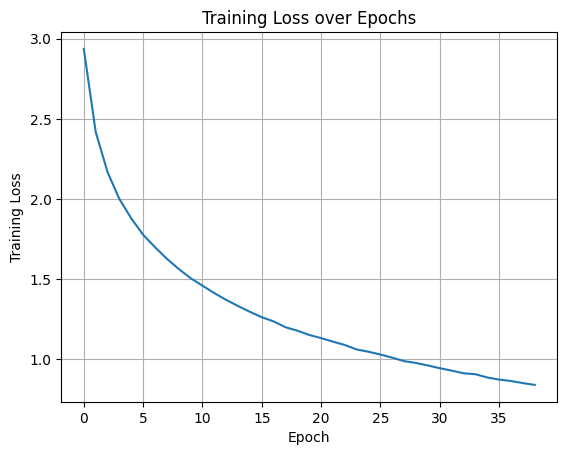

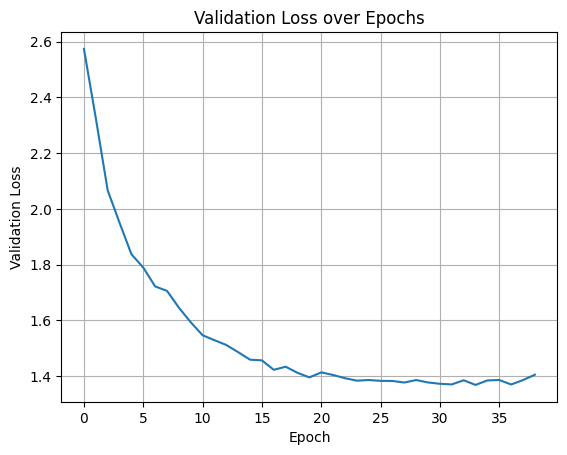

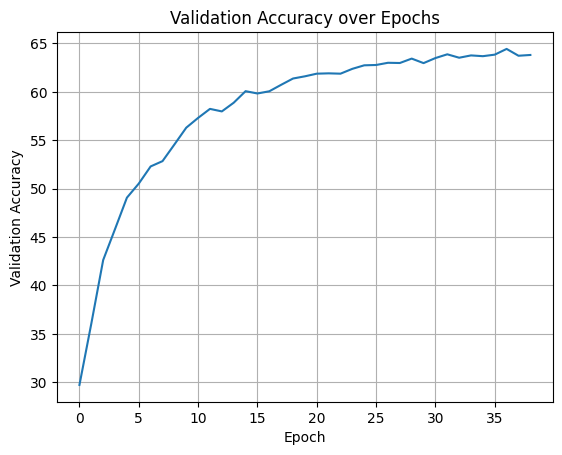

In [10]:
max_num_epochs = 40
patience = 5

validation_losses = []
validation_accuracies = []
train_losses = []

for epoch in range(max_num_epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    running_loss /= len(train_loader)
    print(f"[%d/{max_num_epochs}] Train loss: %.3f" % (epoch + 1, running_loss))
    train_losses.append(running_loss)

    # Validation - calculate loss
    validation_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)
    validation_loss /= len(test_loader)

    # Early stopping
    if epoch > 0 and validation_loss >= validation_losses[-1] * 1.01: # minimum 1% increase
        patience -= 1

    validation_losses.append(validation_loss)
    print(f"Validation loss: {validation_loss:.3f}")
    print(f"Validation accuracy: {validation_accuracy:.2f}%")

    if patience == 0:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Finished Training")

# Plot training losses
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.grid()
plt.show()

# Plot validation losses
plt.plot(validation_losses)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.grid()
plt.show()

# Plot validation accuracies
plt.plot(validation_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid()
plt.show()

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

Accuracy of the network on the test images: 63.80 %


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images = images.to(device)
        # calculate outputs by running images through the network 
        outputs = net(images).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train images: {(100 * correct / total):.2f} %')

Accuracy of the network on the train images: 76.07 %


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        images = images.to(device)
        outputs = net(images).cpu()   
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))


Accuracy for class acoustic is: 40.7 %
Accuracy for class antenna is: 55.0 %
Accuracy for class bacteria is: 65.5 %
Accuracy for class battery is: 48.8 %
Accuracy for class bean  is: 65.6 %
Accuracy for class beetle is: 72.4 %
Accuracy for class bicycle is: 80.6 %
Accuracy for class birch is: 58.7 %
Accuracy for class bird  is: 44.9 %
Accuracy for class bomb  is: 61.9 %
Accuracy for class bread is: 45.9 %
Accuracy for class bridge is: 63.3 %
Accuracy for class camera is: 66.5 %
Accuracy for class carbon is: 42.6 %
Accuracy for class cat   is: 70.9 %
Accuracy for class corn  is: 49.2 %
Accuracy for class crab  is: 57.1 %
Accuracy for class crocodilian is: 60.8 %
Accuracy for class echinoderm is: 60.5 %
Accuracy for class egg   is: 57.4 %
Accuracy for class elephant is: 79.7 %
Accuracy for class fish  is: 61.5 %
Accuracy for class flower is: 91.6 %
Accuracy for class frog  is: 56.1 %
Accuracy for class fungus is: 76.5 %
Accuracy for class gauge is: 61.2 %
Accuracy for class hammer is: 81

In [16]:
# Save the model
state_dict = net.state_dict()
torch.save(state_dict, "simple_model64.tar")